In [1]:
import os

import torch
import pandas

import matplotlib.pyplot as plt
import seaborn
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
!pwd

/Users/iahansen/admin/master_study/P8/repo/BraDD-S1TS/notebooks


In [3]:
#dataset_folder = '../../data/BraDD-S1TS_zenodo/Samples/'
dataset_folder = '../../../data/BraDD-S1TS_zenodo'


In [4]:
meta_df = pandas.read_csv(os.path.join(dataset_folder, 'meta.csv'), index_col=0)
total_sample = meta_df.shape[0]
meta_df.head()

,alert_idx,center_idx,date,sampling_type,state,file,close_set
0,0,0,2021-08-21,positive,PA,0000000_2021-08-21.pt,train
1,1,1,2020-09-20,positive,AM,0000001_2020-09-20.pt,train
2,2,2,2020-08-08,boundary,PA,0000002_2020-08-08.pt,validation
3,4,3,2020-07-24,positive,PA,0000003_2020-07-24.pt,train
4,5,4,2020-08-06,boundary,PA,0000004_2020-08-06.pt,train


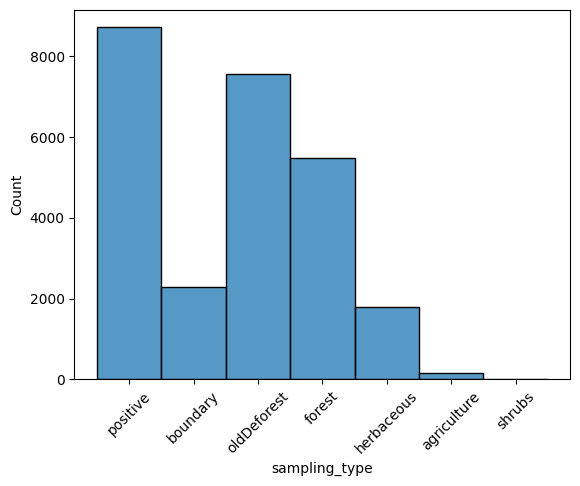

sampling_type
positive       8712
oldDeforest    7557
forest         5472
boundary       2294
herbaceous     1780
agriculture     152
shrubs           21
Name: count, dtype: int64


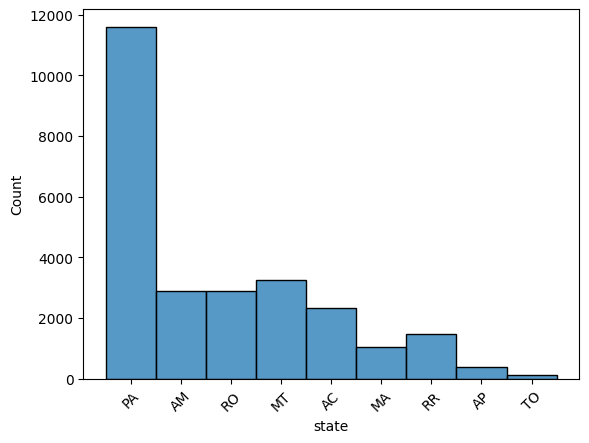

state
PA    11604
MT     3264
AM     2901
RO     2875
AC     2329
RR     1457
MA     1048
AP      390
TO      120
Name: count, dtype: int64


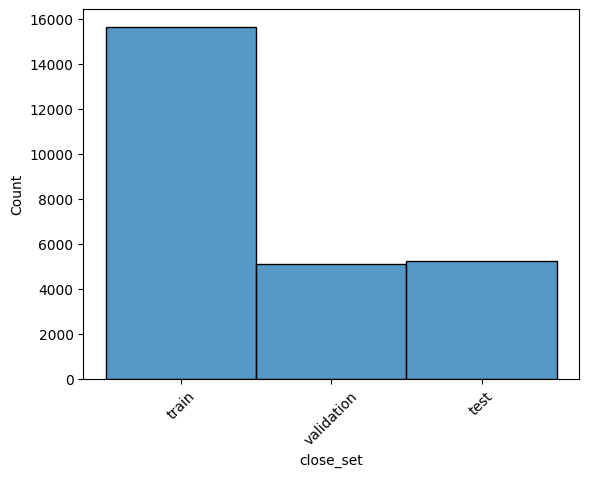

close_set
train         15625
test           5251
validation     5112
Name: count, dtype: int64


In [11]:
for k in ['sampling_type', 'state', 'close_set']:
    seaborn.histplot(data=meta_df, x=k)
    plt.xticks(rotation=45)
    plt.show()
    print(meta_df[k].value_counts())

In [12]:
def read_sample(index: int) -> dict:
    file = meta_df['file'].iloc[index]
    return torch.load(os.path.join(dataset_folder, 'Samples', file))

sample = read_sample(0)
for k, v in sample.items():
    if isinstance(v, torch.Tensor):
        print(k, v.dtype, v.shape)

    elif isinstance(v, list):
        print(k, 'list', len(v))

    else:
        print(k, type(v))


image_dates list 31
label_dates list 2
image torch.float32 torch.Size([31, 2, 48, 48])
label torch.int64 torch.Size([2, 48, 48])


/var/folders/g2/dzp3slfd60gf5l4t1gc94hxm0000gp/T/ipykernel_35261/8174323.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(os.path.join(dataset_folder, '

In [13]:
transition_vector = torch.zeros(4, dtype=torch.int)  # Order: 0 -> 0 [still-forest] | 0 -> 1 [deforest] | 1 -> 0 [reforest] | 1 -> 1 [still-deforest]
num_bins = 100
min_value = -50.0
max_value = 0.0
histogram_list = [[torch.zeros(num_bins + 1, dtype=torch.int) for i in range(2)] for j in range(4)]
wb = tqdm(total=total_sample)
for idx in range(total_sample):
    sample = read_sample(idx)
    old_mask = sample['label'][0].long()
    new_mask = sample['label'][1].long()
    image_values = torch.clamp((sample['image'] - min_value) / (max_value - min_value), min=0.0, max=1.0) * num_bins
    transition_values = (new_mask + (old_mask * 2))
    transition_vector += torch.bincount(transition_values.view(-1), minlength=4)
    for j in range(4):
        for i in range(2):
            histogram_list[j][i] += torch.bincount(image_values[:, i, transition_values == j].int().view(-1), minlength=num_bins + 1)

    wb.update()

wb.close()
total_spatial_pixel = transition_vector.sum().item()
for i, k in enumerate(['Still Forest', 'Deforest', 'Reforest', 'Still Deforest']):
    print(k, transition_vector[i].item() / total_spatial_pixel * 100.0,transition_vector[i].item())


  0%|          | 0/25988 [00:00<?, ?it/s]

/var/folders/g2/dzp3slfd60gf5l4t1gc94hxm0000gp/T/ipykernel_35261/8174323.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(os.path.join(dataset_folder, '

Still Forest 83.27221237526294 49860363
Deforest 15.85800684717733 9495196
Reforest 0.8697807775597285 520793
Still Deforest 0.0 0


No Change 83.27221237526294 49860363
Deforest 15.85800684717733 9495196
Regrow 0.8697807775597285 520793
Deforest Again 0.0 0


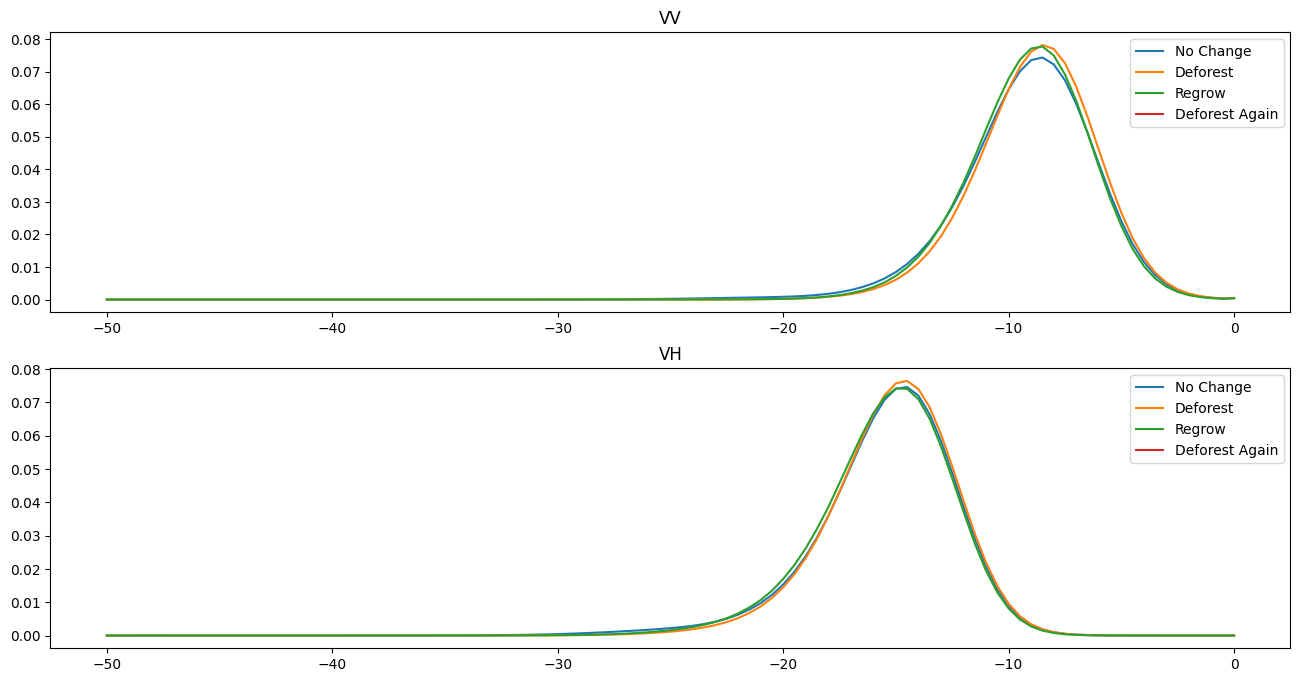

In [8]:
total_spatial_pixel = transition_vector.sum().item()
names = ['No Change', 'Deforest', 'Regrow', 'Deforest Again']
for i, k in enumerate(names):
    print(k, transition_vector[i].item() / total_spatial_pixel * 100.0,transition_vector[i].item())

plt.figure(figsize=(16, 8))
for j, polarization in enumerate(['VV', 'VH']):
    plt.subplot(2, 1, j+1)
    for i in range(4):
        plt.plot(torch.linspace(min_value, max_value, num_bins + 1), histogram_list[i][j] / histogram_list[i][j].sum())
    plt.legend(names)
    plt.title(polarization)
plt.show()